Analysis the results in individual level

# Import some pkgs

In [2]:
import sys
sys.path.append("./mypkg")

import scipy

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
# 
from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict
from collections import defaultdict as ddict
from IPython.display import display
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch
from utils.measures import reg_R_fn, lin_R_fn
plt.style.use(FIG_ROOT/"base.mplstyle")

# Some fns

In [113]:
def _minmax_vec(x):
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    x = x.astype(float)
    if np.max(x) == np.min(x):
        return x
    return (x-np.min(x))/(np.max(x)-np.min(x))
# minmax vec, but keep the sign
def _pn_minmax(vec):
    def _minmax_vec(x, miniv=None):
        if not isinstance(x, np.ndarray):
            x = np.array(x)
        x = x.astype(float)
        if np.max(x) == np.min(x):
            return x
        if miniv is None:
            miniv = np.min(x)
        return (x-miniv)/(np.max(x)-miniv)
    vec_copy = vec.copy()
    pvec = vec[vec>0]
    nvec = vec[vec<0]

    if len(pvec)>1:
        if pvec.std() < 1e-3:
            miniv = np.min(pvec) - (np.max(pvec) - np.min(pvec))/2
        else:
            miniv = np.min(pvec) - (np.max(pvec) - np.min(pvec))/10
        vec_copy[vec>0] = _minmax_vec(pvec, miniv=miniv)
    if len(nvec)>1:
        if nvec.std() < 1e-3:
            miniv = np.min(-nvec) - (np.max(-nvec) - np.min(-nvec))/2
        else:
            miniv = np.min(-nvec) - (np.max(-nvec) - np.min(-nvec))/10
        vec_copy[vec<0] = -_minmax_vec(-nvec, miniv=miniv)
    return vec_copy

_remove_norm = lambda x: x/np.linalg.norm(x)
_std_vec = lambda x: (x-np.mean(x))/np.std(x)
_remove_scale = _minmax_vec
uptri_idxs = np.triu_indices(68, k=1);
# transfer vec to a sym mat
def _vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

In [6]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr

def divide_fc(fc):
    """Divide the FC into three blocks and vectorize them
    """
    size_fc = len(fc)
    hs_fc = int(size_fc/2)
    fc_block1 = fc[:hs_fc, :hs_fc]
    fc_block2 = fc[hs_fc:, hs_fc:];
    fc_block3 = fc[:hs_fc, hs_fc:];
    vec1 = _remove_scale(fc_block1[np.triu_indices(hs_fc, k = 1)])
    vec2 = _remove_scale(fc_block2[np.triu_indices(hs_fc, k = 1)])
    vec3 = _remove_scale(fc_block3.flatten())
    return vec1, vec2, vec3

def cal_metrics(fc1, fc2):
    """Calculate the distance between fc1 and fc2, including
        1. geodesic dist
        2. pearson's R
        3. lin R
        4. pearson's R after divide the FC into three blocks
        5. lin R after divide the FC into three blocks
    """
    fc1 = fc1.astype(np.float64)
    fc2 = fc2.astype(np.float64)
    size_fc = len(fc1)
    
    fc1_c = _remove_scale(fc1[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    fc2_c = _remove_scale(fc2[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    
    
    
    # all metrics
    reg_r = reg_R_fn(fc1_c, fc2_c)
    lin_r = lin_R_fn(fc1_c, fc2_c)
    mse = np.mean((fc1_c-fc2_c)**2)
    
    
    res = edict()
    res.reg_r = reg_r[0]
    res.lin_r = lin_r[0]
    res.mse = mse
    return res

def cal_metrics_batch(fc1s, fc2s):
    """fc1s, fc2s: num_fc x 68 x 68
    """
    ress = ddict(list)
    for ix in range(len(fc1s)):
        fc_t = fc2s[ix]
        fc_e = fc1s[ix]
        res = cal_metrics(fc_t, fc_e)
        for key, v in res.items():
            ress[key].append(v)
    
    return ress

# Load data and params

In [7]:
paras = edict()
paras.bds = ["delta", "theta", "alpha", "beta_l"]
#paras.bds = ["alpha"]
paras.allbds = ["delta", "theta", "alpha", "beta_l"]
paras.add_v = 0.01
paras.nepoch = 100

paras.delta = [2, 3.5]
paras.theta = [4, 7]
paras.alpha = [8, 12]
paras.beta_l = [13, 20]

In [10]:
# em FC
fc_root = RES_ROOT/"emp_fcs2"
def _get_fc(sub_ix, bd):
    fil = list(fc_root.rglob(f"*{bd}*{paras.nepoch}/sub{sub_ix}.pkl"))[0]
    return np.abs(load_pkl(fil, verbose=False))

In [11]:

def _add_v2con(cur_ind_conn, add_v):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.quantile(cur_ind_conn, 0.99)*add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn


In [12]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values;
#scs = ind_conn.transpose(2, 0, 1)[:, :68, :68];
#scs = np.array([_preprocess_sc(sc) for sc in scs]);

scs = []
for cur_ind_idx in range(36):
    # create spectrome brain:
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
     # re-assign connectome to individual connectome
    brain.connectome =  _add_v2con(ind_conn[:, :, cur_ind_idx], paras.add_v)
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    sc = brain.reducedConnectome
    scs.append(sc[:68, :68])
scs = np.array(scs)
scs.shape

(36, 68, 68)

# Compare all methods

In [14]:
key_names = ['mse', 'lin_r', 'reg_r']
method_names = [
                "SGM-SBI", 
                "SGM-SBI-shared", 
                "Direct", 
                ]
band_res = edict()
for band in paras.allbds:
    sbi_ann_res = load_pkl(RES_ROOT/(f"rawfc2_SBIxANNBW_{band}_"
                                     f"ep{paras.nepoch}_"
                                     f"num1000_densitynsf_MR3_noise_sd120_"
                                     f"addv{paras.add_v*100:.0f}"
                                     f"/inf_res.pkl"), verbose=False);
    sbi_ann_ab_res = load_pkl(RES_ROOT/(f"rawfc2allbd_SBIxANNALLBD_"
                                        f"{'-'.join(paras.allbds)}_"
                                        f"ep{paras.nepoch}_"
                                        f"num1000_densitynsf_MR3_noise_sd120_"
                                        f"addv{paras.add_v*100:.0f}"
                                        f"/inf_res.pkl"), verbose=False);
    empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    
    fcss = edict()
    fcss["SGM-SBI"] = np.array([np.abs(est_FC) for est_FC in sbi_ann_res.est_FCs]);
    fcss["SGM-SBI-shared"]= np.array([np.abs(est_FC) for est_FC in sbi_ann_ab_res[f"est_FCs_{band}"]])
    fcss["Direct"] = scs
    
    ress = edict()
    ress_full = edict()
    for key in method_names:
        tres =  pd.DataFrame(cal_metrics_batch(fcss[key], empfcs));
        ress_full[key] = tres
        ress[key] = tres.mean()[key_names]
    
    out_df = pd.DataFrame(ress).T
    print(f"Results of {band}")
    display(out_df)
    band_res[band] = ress_full

Results of delta


,mse,lin_r,reg_r
SGM-SBI,0.052167,0.435688,0.442424
SGM-SBI-shared,0.048318,0.41571,0.436105
Direct,0.099926,0.288508,0.405613


Results of theta


,mse,lin_r,reg_r
SGM-SBI,0.052011,0.424801,0.449915
SGM-SBI-shared,0.051018,0.40009,0.44874
Direct,0.095726,0.300449,0.413894


Results of alpha


,mse,lin_r,reg_r
SGM-SBI,0.05355,0.336625,0.424006
SGM-SBI-shared,0.055691,0.333647,0.43677
Direct,0.088679,0.320667,0.429861


Results of beta_l


,mse,lin_r,reg_r
SGM-SBI,0.052297,0.278027,0.307129
SGM-SBI-shared,0.05508,0.223642,0.257518
Direct,0.084904,0.327686,0.432767


## Select representative subject

In [15]:
sel_metric = "reg_r"
sel_method = "SGM-SBI"
sel_band = "alpha"
# based on the alpha band, reg_r, SGM-SBI
def get_rep_sub(vec, num_sub):
    diffs = np.abs(vec - np.mean(vec))
    sub_idxs = np.argsort(diffs)[:num_sub]
    return sub_idxs

vecs= []
if sel_band is None:
    for band in paras.bds:
        vecs.append(_std_vec(band_res[band][sel_method][sel_metric]))
    mvec = np.mean(np.array(vecs), axis = 0)
else:
    mvec = np.array(_std_vec(band_res[sel_band][sel_method][sel_metric]))
rep_sub_idxs = get_rep_sub(mvec, num_sub=2);rep_sub_idxs


array([5, 6])

# Plot

In [17]:
import matplotlib 
#cmap = cm.get_cmap("tab10");
cmap = matplotlib.colormaps.get_cmap("tab10")
all_methods = [
                "SGM-SBI", 
                "SGM-SBI-shared", 
                "Direct"];
cols = cmap(np.linspace(0, 1, len(all_methods)));

In [18]:
from forward import network_transfer_macrostable as nt

par_low = np.asarray([0.005, 5, 0.1])
par_high = np.asarray([0.03, 20, 1])
prior_bds = np.array([par_low, par_high]).T;
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=1), prior_bds=prior_bds);

def _get_lam(raw_params, brain, freq):
    params = _theta_raw_2out(raw_params)
    
    params_dict = dict()
    params_dict["tauC"] =  params[0]
    params_dict["speed"] =  params[1]
    params_dict["alpha"] =  params[2]
    _, U, flam, lam = nt.network_transfer_local_fc_alpha(brain , params_dict, freq, is_full=True)
    return U[:68, :68], flam[:68], lam[:68]

brains = []
for cur_ind_idx in range(36):
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  _add_v2con(ind_conn[:, :, cur_ind_idx], paras.add_v)
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    brains.append(brain)

## FC heatmap

In [19]:

band_fc_res = edict()
for band in paras.allbds:
    _trans_fn = lambda fc: _vec_2mat(_minmax_vec(fc[uptri_idxs]))
    sbi_ann_res = load_pkl(RES_ROOT/(f"rawfc2_SBIxANNBW_{band}_"
                                     f"ep{paras.nepoch}_"
                                     f"num1000_densitynsf_MR3_noise_sd120_"
                                     f"addv{paras.add_v*100:.0f}"
                                     f"/inf_res.pkl"), verbose=False);
    sbi_ann_ab_res = load_pkl(RES_ROOT/(f"rawfc2allbd_SBIxANNALLBD_"
                                        f"{'-'.join(paras.allbds)}_"
                                        f"ep{paras.nepoch}_"
                                        f"num1000_densitynsf_MR3_noise_sd120_"
                                        f"addv{paras.add_v*100:.0f}"
                                        f"/inf_res.pkl"), verbose=False);
    empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    
    fcss = edict()
    fcss["SGM"] = np.array([_trans_fn(np.abs(est_FC)) 
                                    for est_FC in sbi_ann_res.est_FCs]);
    fcss["SGMAB"]= np.array([_trans_fn(np.abs(est_FC) )
                                         for est_FC in sbi_ann_ab_res[f"est_FCs_{band}"]])
    fcss["SC"] = scs
    fcss["efc"] = np.array([_trans_fn(np.abs(fc)) for fc in empfcs])
    band_fc_res[band] = fcss

In [36]:
def fc_corr_fn(fc1, fc2):
    idxs = np.triu_indices_from(fc1, k=1);
    vec1 = fc1[idxs]
    vec2 = fc2[idxs]
    return scipy.stats.pearsonr(vec1, vec2)[0]

for band in paras.allbds:
    fcss = band_fc_res[band]    
    corrs1 = np.array([fc_corr_fn(fc1, fc2) for fc1, fc2 in zip(fcss["efc"], fcss["SGM"])])
    corrs2 = np.array([fc_corr_fn(fc1, fc2) for fc1, fc2 in zip(fcss["efc"], fcss["SGMAB"])])
    corrs3 = np.array([fc_corr_fn(fc1, fc2) for fc1, fc2 in zip(fcss["SGM"], fcss["SGMAB"])])
    print(band, corrs1[rep_sub_idxs], corrs2[rep_sub_idxs], corrs3[rep_sub_idxs])


delta [0.36389612 0.42865617] [0.369478   0.41808477] [0.99569912 0.97505767]
theta [0.45262689 0.42238566] [0.4517218  0.42961249] [0.99717148 0.99424193]
alpha [0.42373137 0.42436234] [0.42513034 0.4184348 ] [0.99948608 0.99568819]
beta_l [0.2553516  0.28746619] [0.212225   0.23399987] [0.76319709 0.73927129]


In [37]:
fcss["efc"].shape

(36, 68, 68)

In [43]:
sub_idx = rep_sub_idxs[0]
for sub_idx in rep_sub_idxs:
    for ix in range(4):
        for iy in range(ix+1, 4):
            band1 = paras.allbds[ix]
            band2 = paras.allbds[iy]
            print(sub_idx, band1, band2, 
                  fc_corr_fn(band_fc_res[band1]["efc"][sub_idx] , 
                  band_fc_res[band2]["efc"][sub_idx]))

5 delta theta 0.832687462784839
5 delta alpha 0.6960504868485349
5 delta beta_l 0.8193826763346799
5 theta alpha 0.7537377132068768
5 theta beta_l 0.8738236023649022
5 alpha beta_l 0.7090362701160566
6 delta theta 0.8274905324842408
6 delta alpha 0.8439381967014037
6 delta beta_l 0.8498894035488384
6 theta alpha 0.8489764777810891
6 theta beta_l 0.8287502748753848
6 alpha beta_l 0.8659310776619519


In [21]:
# output FCs
for band in paras.allbds:
    fcss = band_fc_res[band]
    for key in ["efc", "SGM", "SGMAB"]:
        for sub_ix in rep_sub_idxs:
            sns.heatmap(fcss[key][sub_ix],
                        square=True, vmax=1, vmin=0, 
                        cbar=False, cmap="viridis")
            plt.yticks([])
            plt.xticks([]);
            plt.savefig(FIG_ROOT/f"revisionR1/FC_{band}_{key}_sub{sub_ix}.jpg")
            plt.close()

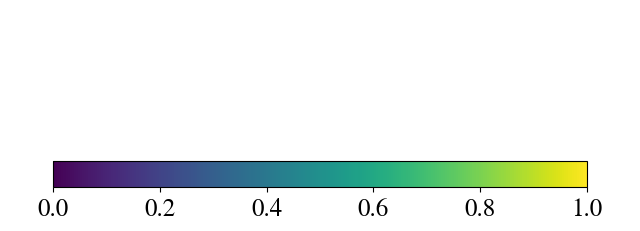

In [22]:
# get colorbar
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(8, 2))
plt.subplots_adjust(top=1)
sm = mpl.cm.ScalarMappable(cmap='viridis')
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
ax.axis('off')

plt.savefig(FIG_ROOT/f"revisionR1/FC_colorbar.jpg")

## KDE

In [23]:
from scipy.stats import gaussian_kde
from scipy.signal import savgol_filter
def _kde_plot(vec, prior_bd, label):
    kde = gaussian_kde(vec);
    xrange = np.linspace(prior_bd[0]*0.5,  prior_bd[1]*1.2, 200)
    kde_values = kde(xrange)+1e-2;
    smoothed_kde_values  = np.exp(savgol_filter(np.log(kde_values), window_length=7, polyorder=1))
    smoothed_kde_values = smoothed_kde_values/smoothed_kde_values.mean()/np.diff(prior_bd)
    plt.plot(xrange, smoothed_kde_values, label=label)

names = ["TauC", "Speed", "alpha"]
latex_names = [r"$\tau_G$ (ms)", r"$v$ (m/s)", r"$\alpha$ (a.u.)"]
par_low = np.asarray([0.005, 5, 0.1])
par_high = np.asarray([0.03, 20, 1])
prior_bds = np.array([par_low, par_high]).T;
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=1), prior_bds=prior_bds);

In [ ]:
post_spss = edict()
for band in paras.allbds:
    print(band)
    bw_res_fils = list(RES_ROOT.glob(f"rawfc2_SBIxANNBW_{band}_"
                  f"ep{paras.nepoch}_"
                  f"num1000_densitynsf_MR3_noise_sd120_"
                  f"addv{paras.add_v*100:.0f}"
                  f"/ind*.pkl"))
    bw_res_fils = sorted(bw_res_fils, key=lambda p: int(p.stem.split("ind")[-1]));
    
    
    post_spss[band] = []
    # only select the representative subjects
    for sub_ix in rep_sub_idxs:
        fil = bw_res_fils[sub_ix]
        res = load_pkl(fil, verbose=False);
        sps = res.sample((1000, ));
        post_sps = _theta_raw_2out(sps.numpy());
        post_spss[band].append(post_sps)

In [25]:
post_spss["allbd"] = []
ab_res_fils = list(RES_ROOT.glob(f"rawfc2allbd_SBIxANNALLBD_"
                                 f"{'-'.join(paras.allbds)}_"
                                 f"ep{paras.nepoch}_"
                                 f"num1000_densitynsf_MR3_noise_sd120_"
                                 f"addv{paras.add_v*100:.0f}"
                                 f"/ind*.pkl"))
ab_res_fils = sorted(ab_res_fils, key=lambda p: int(p.stem.split("ind")[-1]));
for sub_ix in rep_sub_idxs:
    fil = ab_res_fils[sub_ix]
    res = load_pkl(fil, verbose=False);
    sps = res.sample((1000, ));
    post_sps = _theta_raw_2out(sps.numpy());
    post_spss["allbd"].append(post_sps)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
bd_names = ["delta", "theta", "alpha", "beta_l", "allbd"]
bd_names_plot = ["Delta", "Theta", "Alpha", "Beta", "Band-shared"]
_prefn = lambda x: np.array(x)
def _bw_fn(v):
    if v > 0.1:
        return 0.5
    elif v > 0.01:
        return 2
    elif v > 0.0005:
        return 10 
    else:
        return 100

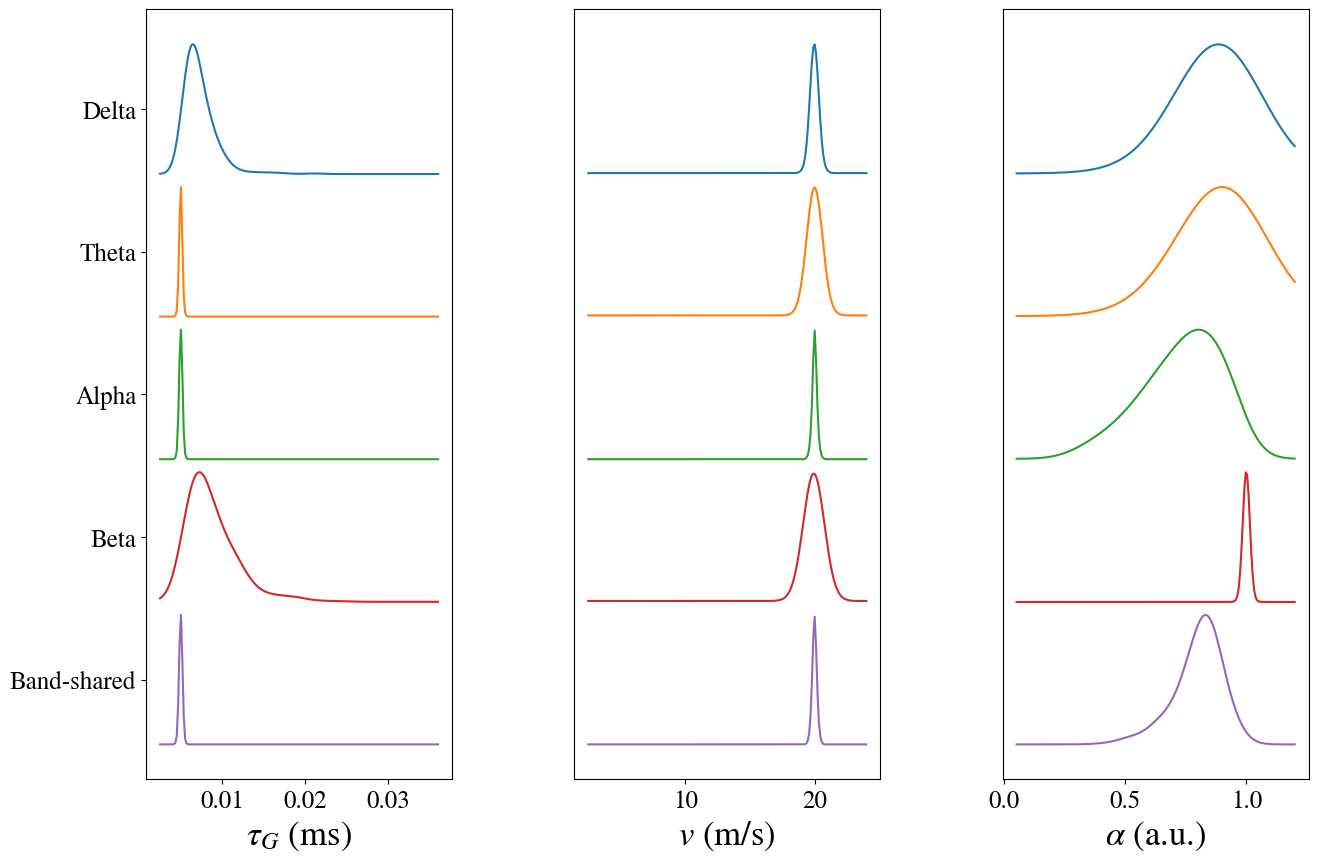

In [27]:
sub_ix_raw = 0 # the index of the representative subject for rep_sub_idxs

intv = 1.1
plt.figure(figsize=[15, 10])
for para_idx in [0, 1, 2]:
    prior_bd = prior_bds[para_idx]
    xrange = np.linspace(prior_bd[0]*0.5,  prior_bd[1]*1.2, 200)
    
    plt.subplot(1, 3, para_idx+1)
    for ix, cur_bd in enumerate(bd_names):
        cur_data = _prefn(post_spss[cur_bd][sub_ix_raw]);
        vec = cur_data[:, para_idx]
        stdm = vec.std()/vec.mean()
        kde = gaussian_kde(vec, bw_method=_bw_fn(stdm));
        kde_values = kde(xrange)+1e-2;
        smoothed_kde_values  = np.exp(savgol_filter(np.log(kde_values), window_length=7, polyorder=1))
        kde_values_norm = smoothed_kde_values/smoothed_kde_values.max();
        plt.plot(xrange, kde_values_norm+(len(bd_names)-ix-1)*intv)
    ytick_locs = 0.5+np.arange(0, 5)*intv
    if para_idx == 0:
        plt.yticks(ytick_locs, bd_names_plot[::-1])
    else:
        plt.yticks([])
    plt.xlabel(latex_names[para_idx])
plt.savefig(FIG_ROOT/f"revisionR1/norm_KDE_sub{rep_sub_idxs[sub_ix_raw]}.jpg")

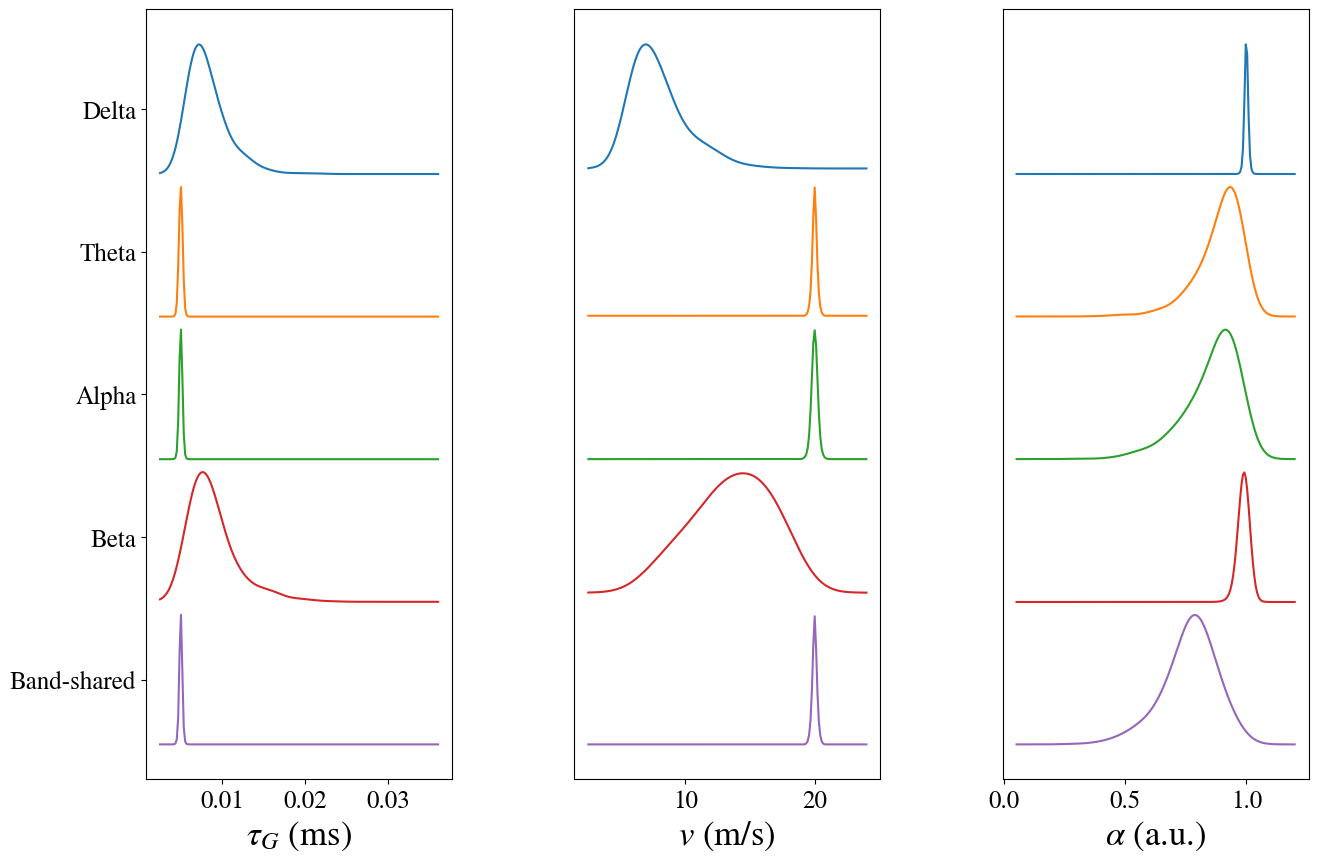

In [28]:
sub_ix_raw = 1 # the index of the representative subject for rep_sub_idxs

intv = 1.1
plt.figure(figsize=[15, 10])
for para_idx in [0, 1, 2]:
    prior_bd = prior_bds[para_idx]
    xrange = np.linspace(prior_bd[0]*0.5,  prior_bd[1]*1.2, 200)
    
    plt.subplot(1, 3, para_idx+1)
    for ix, cur_bd in enumerate(bd_names):
        cur_data = _prefn(post_spss[cur_bd][sub_ix_raw]);
        vec = cur_data[:, para_idx]
        stdm = vec.std()/vec.mean()
        kde = gaussian_kde(vec, bw_method=_bw_fn(stdm));
        kde_values = kde(xrange)+1e-2;
        smoothed_kde_values  = np.exp(savgol_filter(np.log(kde_values), window_length=7, polyorder=1))
        kde_values_norm = smoothed_kde_values/smoothed_kde_values.max();
        plt.plot(xrange, kde_values_norm+(len(bd_names)-ix-1)*intv)
    ytick_locs = 0.5+np.arange(0, 5)*intv
    if para_idx == 0:
        plt.yticks(ytick_locs, bd_names_plot[::-1])
    else:
        plt.yticks([])
    plt.xlabel(latex_names[para_idx])
plt.savefig(FIG_ROOT/f"revisionR1/norm_KDE_sub{rep_sub_idxs[sub_ix_raw]}.jpg")

## Brain plot


In [44]:
org_ord = np.loadtxt(DATA_ROOT/"rois_order.txt", dtype=str)
org_ord = np.array([".".join([roi.split("_")[1].lower(), roi.split("_")[0].lower()]) for roi in org_ord][:68])
target_ord = np.loadtxt(DATA_ROOT/"dk68_utils/ROI_order_DK68.txt", dtype=str);
order_idxs = np.where(target_ord.reshape(-1, 1)== org_ord.reshape(1, -1))[-1];
# if a vec is from org_ord, then vec[order_idxs] is with target_ord

In [75]:
from nilearn import plotting
from utils.brain_plot import get_bg_data
import matplotlib as mpl
def _brain_plot(vec, cmap="Reds", threshold=None, vbds=None):
    root = DATA_ROOT/"dk68_utils/"
    h = 0.6
    
    XYZsl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_left.txt")
    facesl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_left.txt").astype(np.int64)
    roi_tmpl = np.loadtxt(root/"brain_tmp_left_DK68.txt");
    bg_datal = get_bg_data(XYZsl, facesl)
    
    XYZsr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_right.txt")
    facesr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_right.txt").astype(np.int64)
    roi_tmpr = np.loadtxt(root/"brain_tmp_right_DK68.txt");
    bg_datar = get_bg_data(XYZsr, facesr)
    
    # map vec to the template
    vecl = roi_tmpl.copy()
    vecr = roi_tmpr.copy()
    for roi_ix in range(1, 35):
        vecl[roi_tmpl==roi_ix] = vec[roi_ix-1]
        vecr[roi_tmpr==roi_ix] = vec[roi_ix-1+34]
        
    if vbds is not None:
        vmin, vmax = vbds
    else:
        vmin, vmax = np.min(vec), np.max(vec)
    #fig, axs = plt.subplots(2, 2, figsize=[10, 10], subplot_kw={'projection': '3d'})
    fig = plt.figure(figsize=(10, 6))
    # left, bottom, width, height
    # facecolor make the bg  transparent
    ax1 = fig.add_axes([0.1,  0.5, h,  h], projection='3d',  facecolor='none')
    ax2 = fig.add_axes([0.15, 0.1, h,  h], projection='3d',  facecolor='none') 
    ax3 = fig.add_axes([0.5,  0.5, h,  h], projection='3d',  facecolor='none')
    ax4 = fig.add_axes([0.47, 0.1, h,  h], projection='3d',  facecolor='none')  
    
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="lateral", axes=ax1, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal, # TO get the depth of the brain plot
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="medial", axes=ax2, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="lateral", axes=ax3, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="medial", axes=ax4, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    
    #fig.text(0.22, 0.36, 'Medial', ha='center', va='center')
    #fig.text(0.22, 0.78, 'Lateral', ha='center', va='center')
    #fig.text(0.24, 0.97, 'Left', ha='center', va='center')
    #fig.text(0.92, 0.97, 'Right', ha='center', va='center')
    #plt.suptitle("-log pvalues", fontsize=30)
    
    #norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    #sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    #sm.set_array([])  
    #cbar_ax = fig.add_axes([.91, .3, .03, .4])
    #fig.colorbar(sm, cax=cbar_ax)
    return fig

In [102]:
band_names = ["Delta", "Theta", "Alpha", "Beta"]
U_res = edict()
for bidx, band in enumerate(paras.allbds):
    lams = []
    Us = []
    
    for sub_idx_raw in range(len(rep_sub_idxs)):
        sub_idx = rep_sub_idxs[sub_idx_raw]
        mid_pt = np.mean(paras[band])
        raw_params = np.mean(np.array(post_spss[band]), axis=1)[sub_idx_raw, :]
        U, flam, lam = _get_lam(raw_params, brains[sub_idx],  mid_pt);
        lam = np.abs(lam)
        
        lams.append(lam)
        Us.append(U)

        idxs = np.argsort(lam)[:3]
        print(idxs)
        
    U_res[band_names[bidx]] = np.array(Us)

[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]


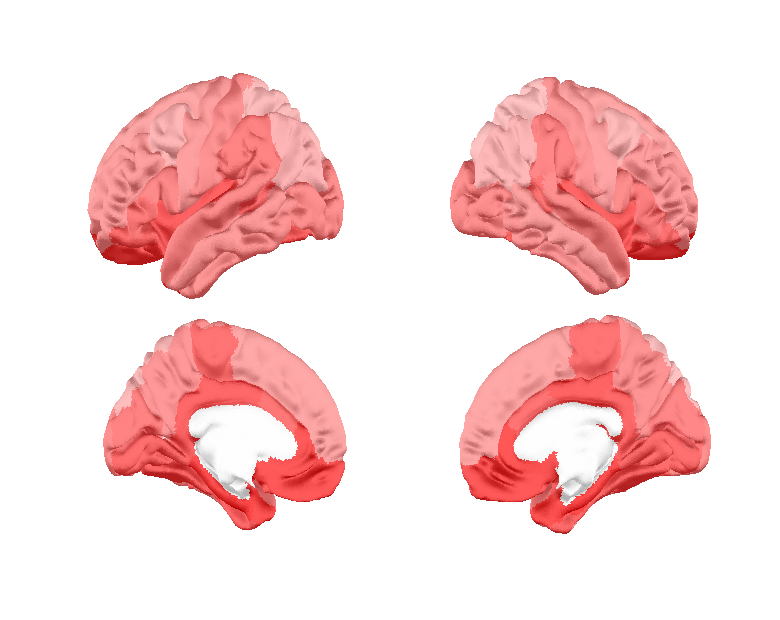

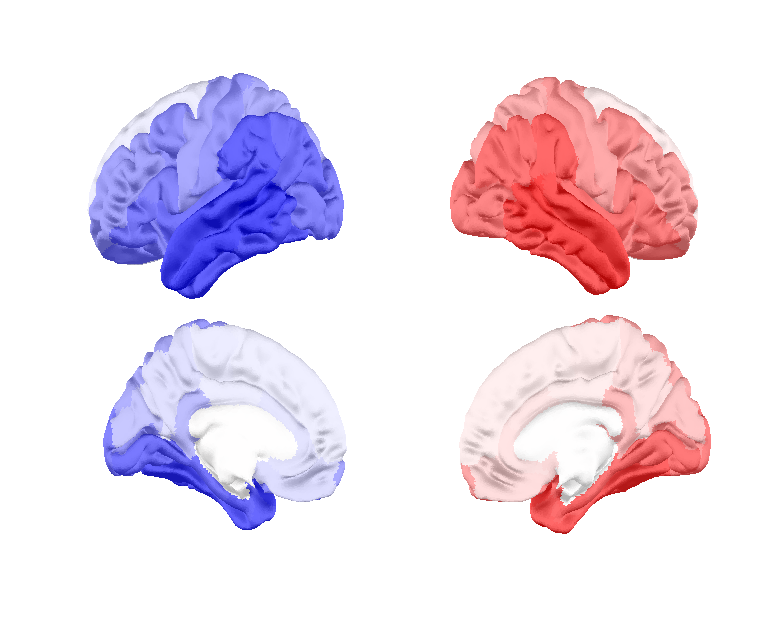

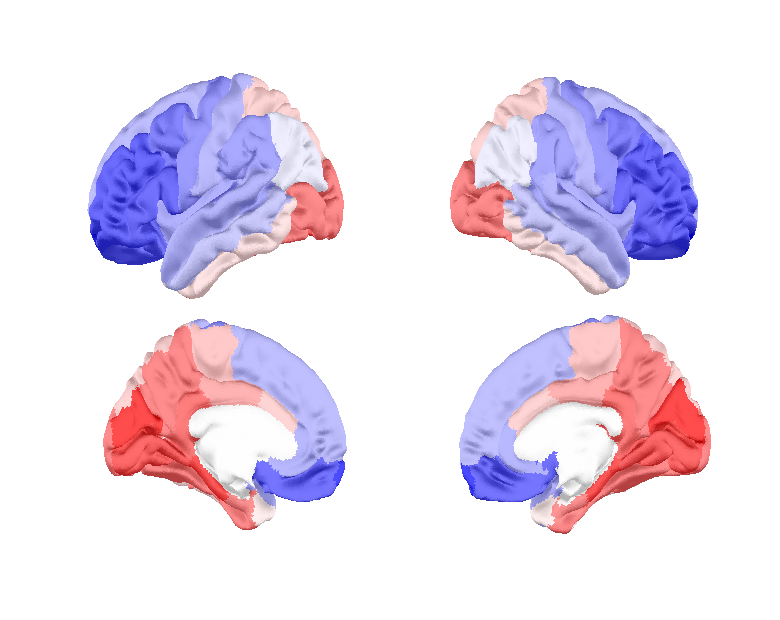

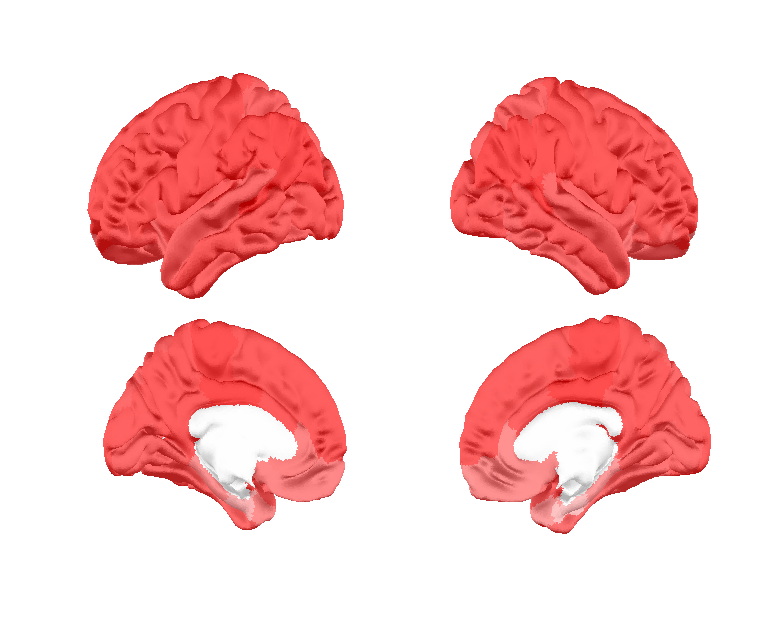

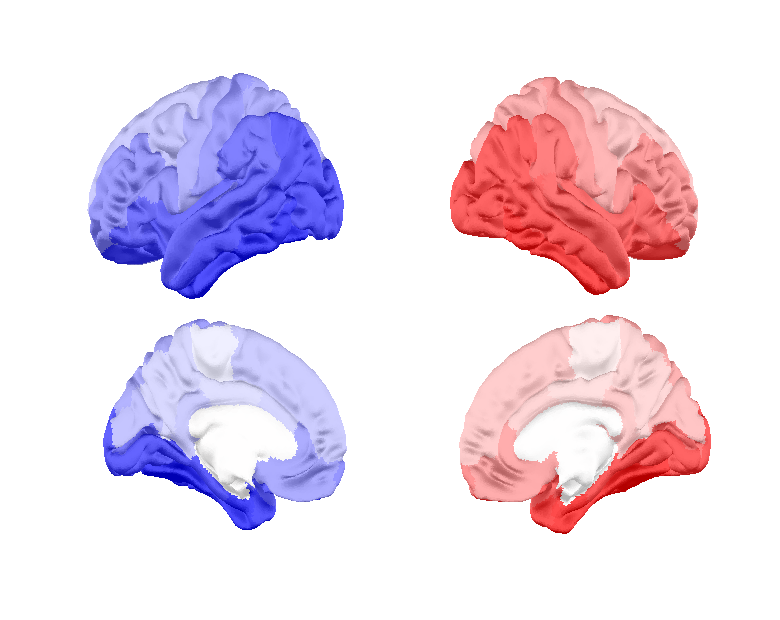

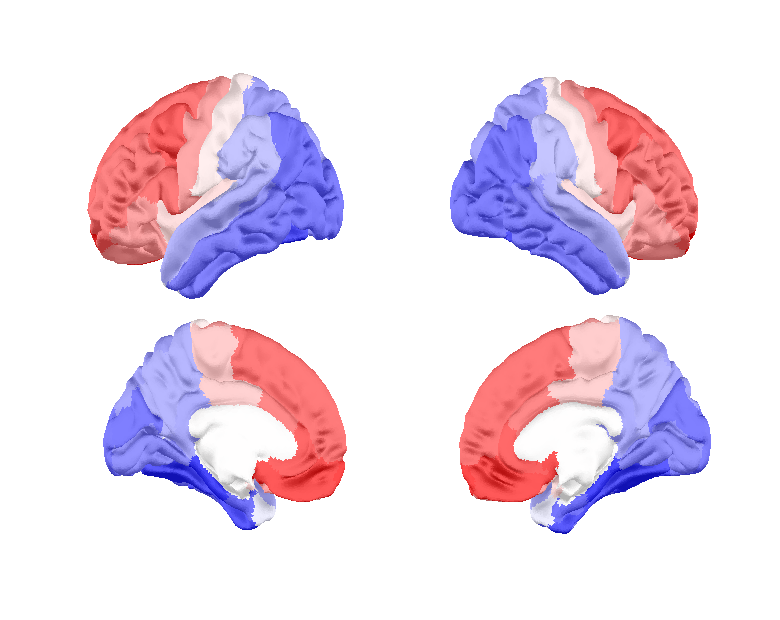

In [114]:
cmap = "bwr"
band_name = "Alpha"
Us = U_res[band_name]
for sub_idx_raw in range(len(rep_sub_idxs)):
    for U_idx in [0, 1, 2]:
        cvec = Us[sub_idx_raw, :, U_idx]
        rvec = cvec.real
        rvec = _pn_minmax(rvec)
        fig = _brain_plot(rvec[order_idxs], cmap=cmap, vbds=[-1, 1]);
        fig.savefig(FIG_ROOT/f"revisionR1/real_U{U_idx}_{band_name}_sub{rep_sub_idxs[sub_idx_raw]}.jpg")
        

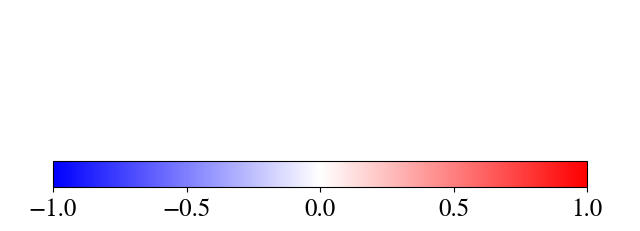

In [34]:
import matplotlib as mpl
vmin, vmax = -1, 1
cmap = "bwr"

fig, ax = plt.subplots(figsize=(8, 2))
plt.subplots_adjust(top=1)

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
ax.axis('off')

plt.savefig(FIG_ROOT/f"revisionR1/brain_{cmap}_colorbar.jpg")